In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16620, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 16620 (delta 55), reused 63 (delta 29), pack-reused 16522
Receiving objects: 100% (16620/16620), 15.16 MiB | 17.91 MiB/s, done.
Resolving deltas: 100% (11412/11412), done.
/kaggle/working/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
Setup complete. Using torch 2.1.2 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="5JnDseY3Ntdoxlcgfuyh")
project = rf.workspace("graduate-na-ni").project("artipath")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [5]:
dataset.location

'/kaggle/working/yolov5/ArtiPath-2'

In [6]:
%cd /kaggle/working/yolov5

/kaggle/working/yolov5


In [7]:
dataset.location

'/kaggle/working/yolov5/ArtiPath-2'

In [13]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- abnormal
nc: 1
roboflow:
  license: Private
  project: artipath
  url: https://app.roboflow.com/graduate-na-ni/artipath/2
  version: 2
  workspace: graduate-na-ni
test: ../test/images
train: ArtiPath-2/train/images
val: ArtiPath-2/valid/images


In [14]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [15]:
#this is the model configuration we will use for our tutorial
%cat /kaggle/working/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [17]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [18]:
%%writetemplate /kaggle/working/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [19]:
import time
import os

start_time = time.time()

# Edit the file utils/dataloaders.py
# Replace np.int with int
!sed -i 's/np\.int/int/g' utils/dataloaders.py

# Run the training command
!python train.py --img 640 --batch 32 --epochs 70 --data {dataset.location}/data.yaml --cfg ./models/yolov5m.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-05-20 13:38:37.093359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 13:38:37.093487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 13:38:37.246895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train:

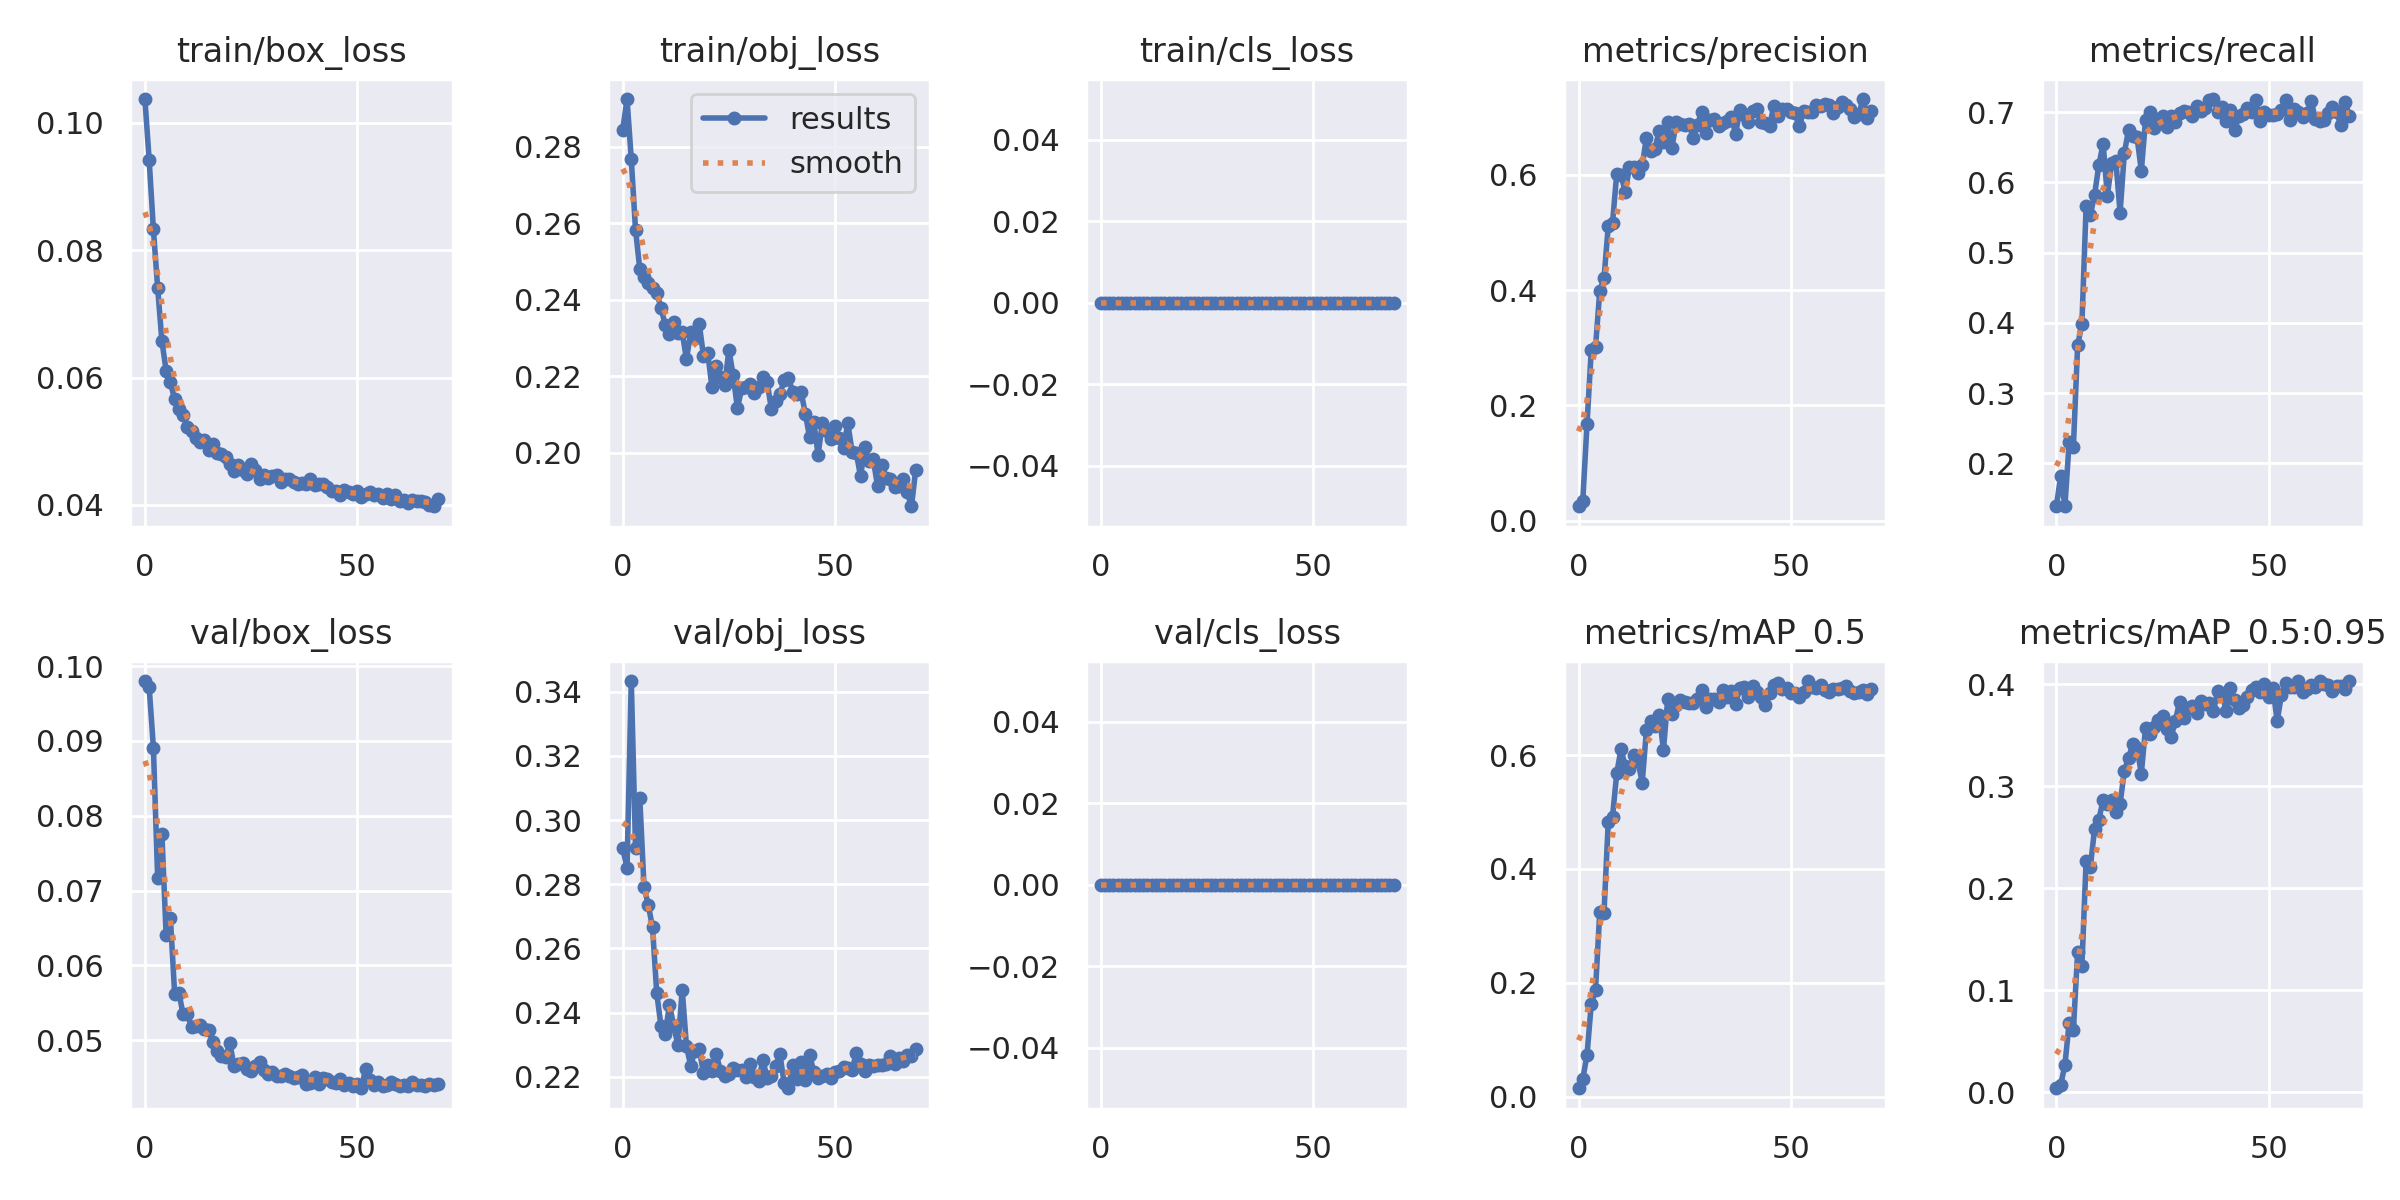

In [20]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

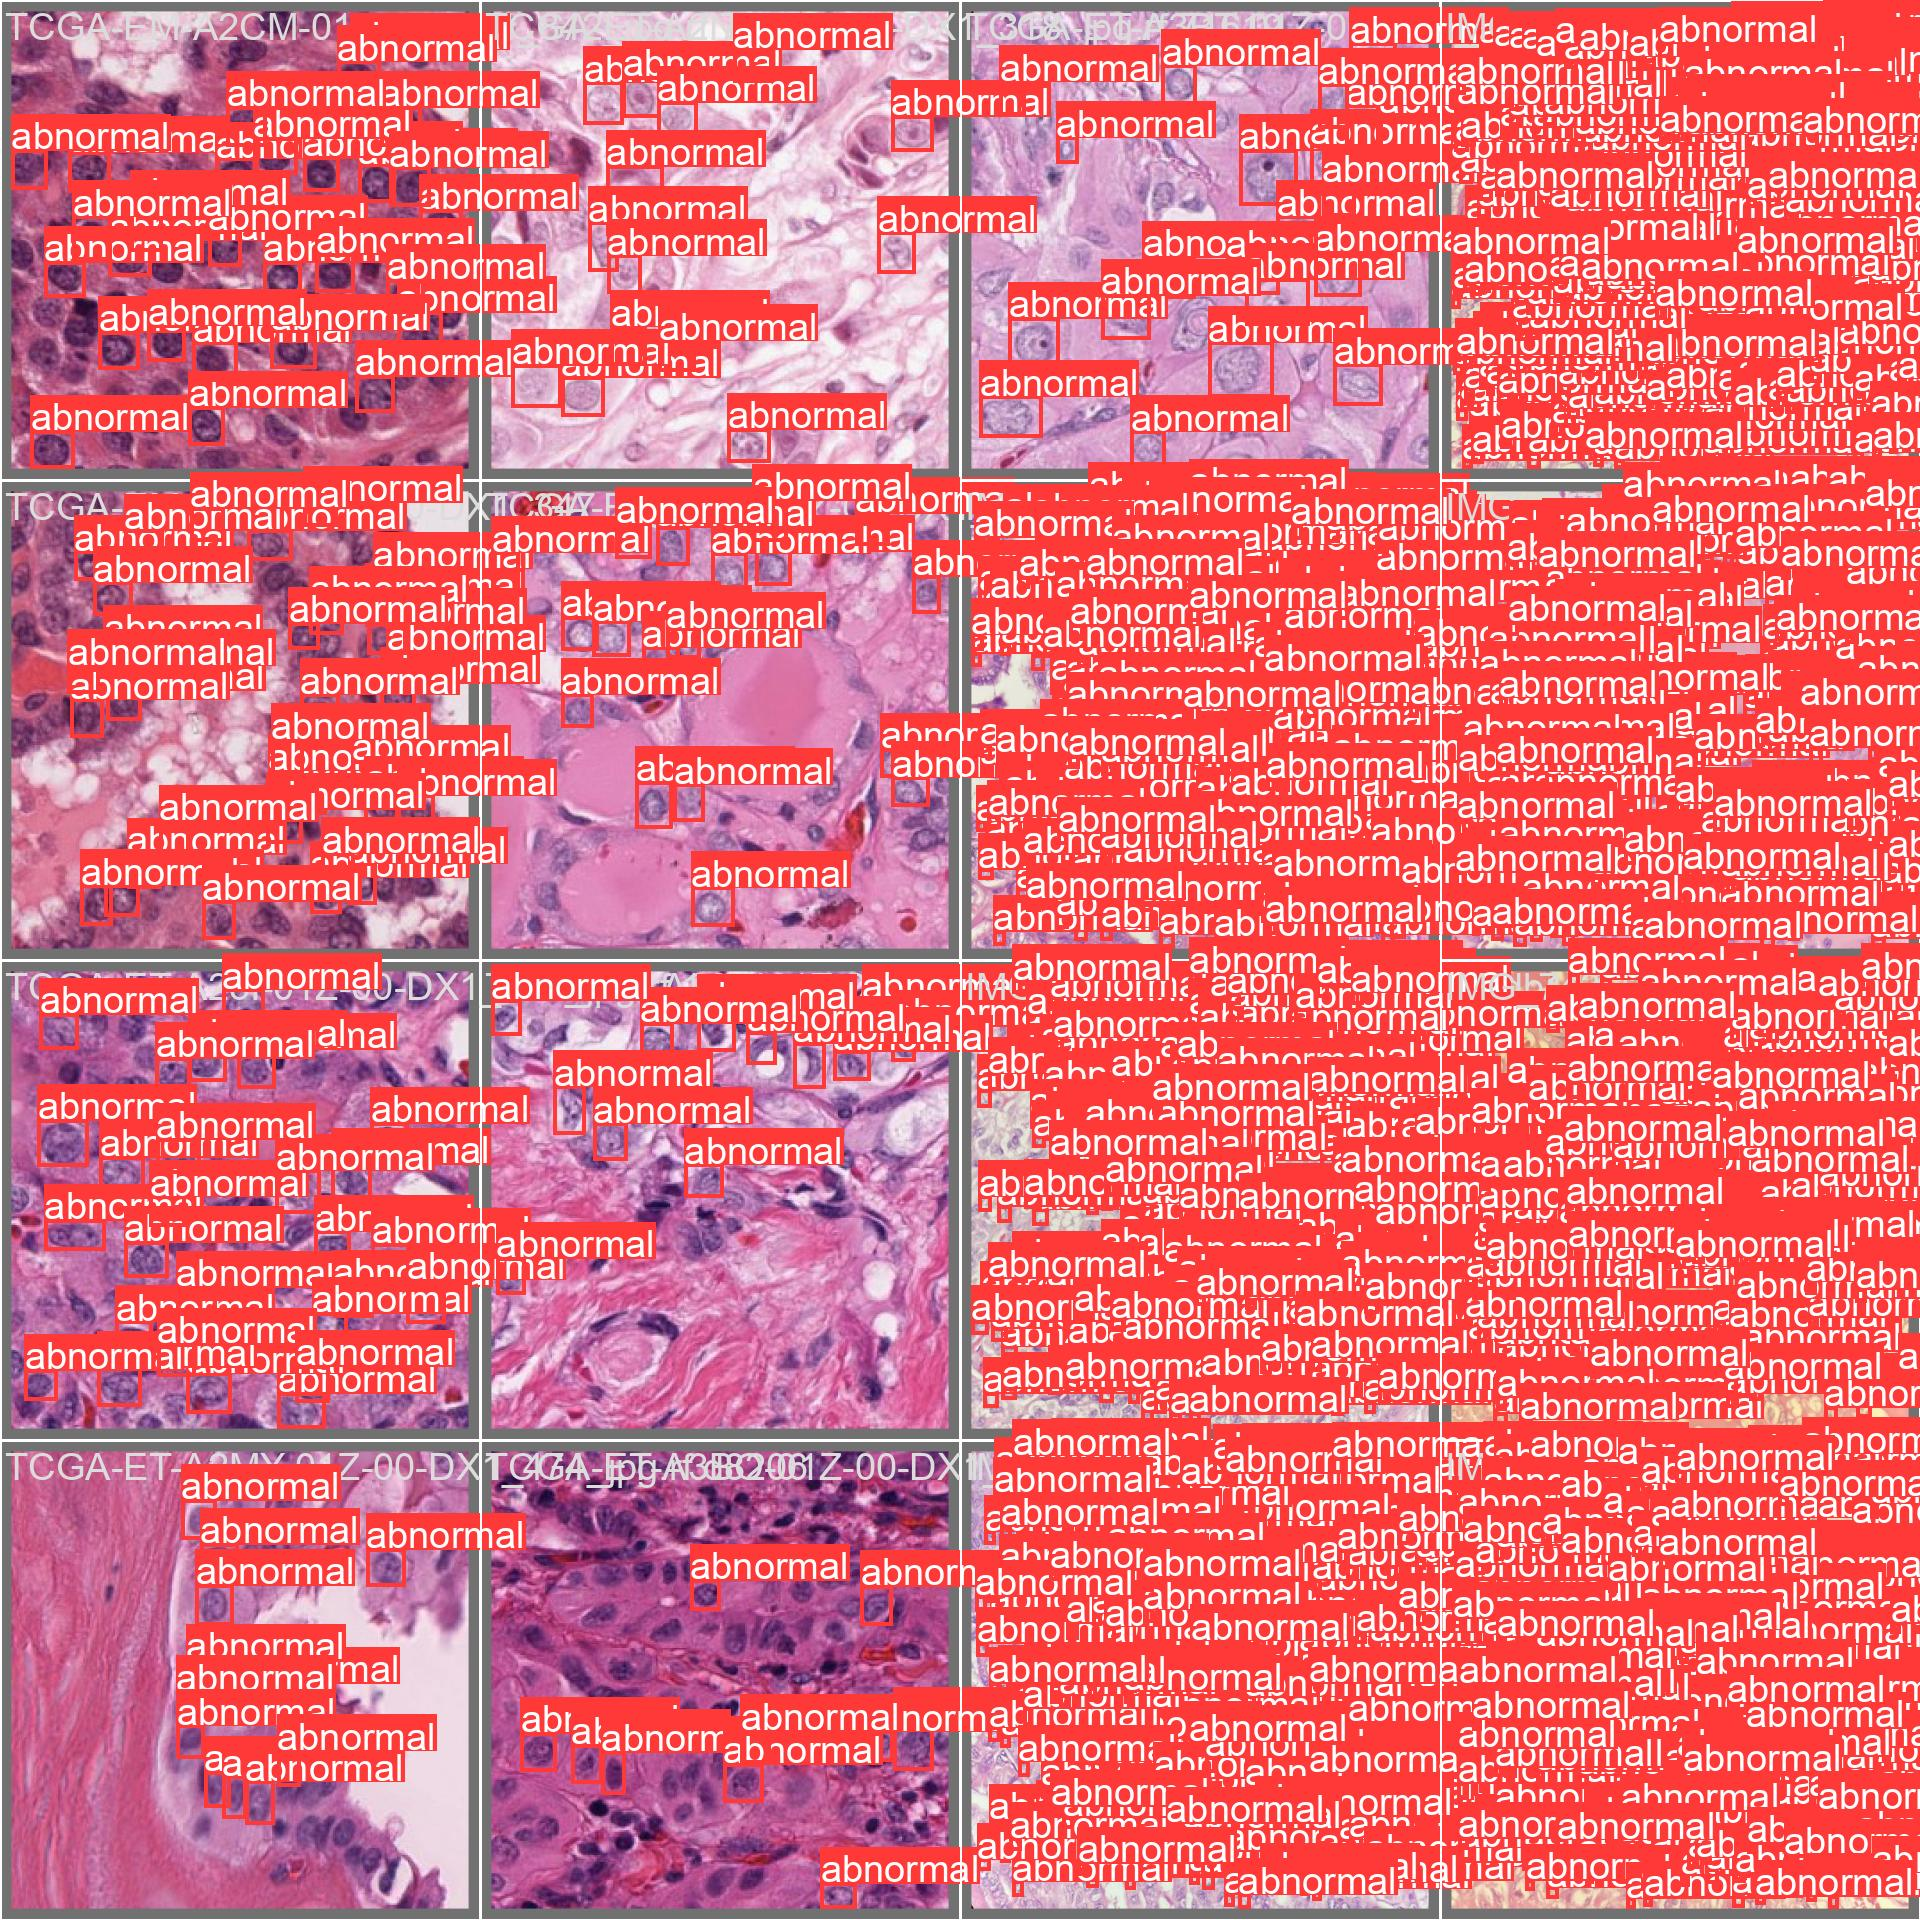

In [21]:
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

In [22]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [23]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


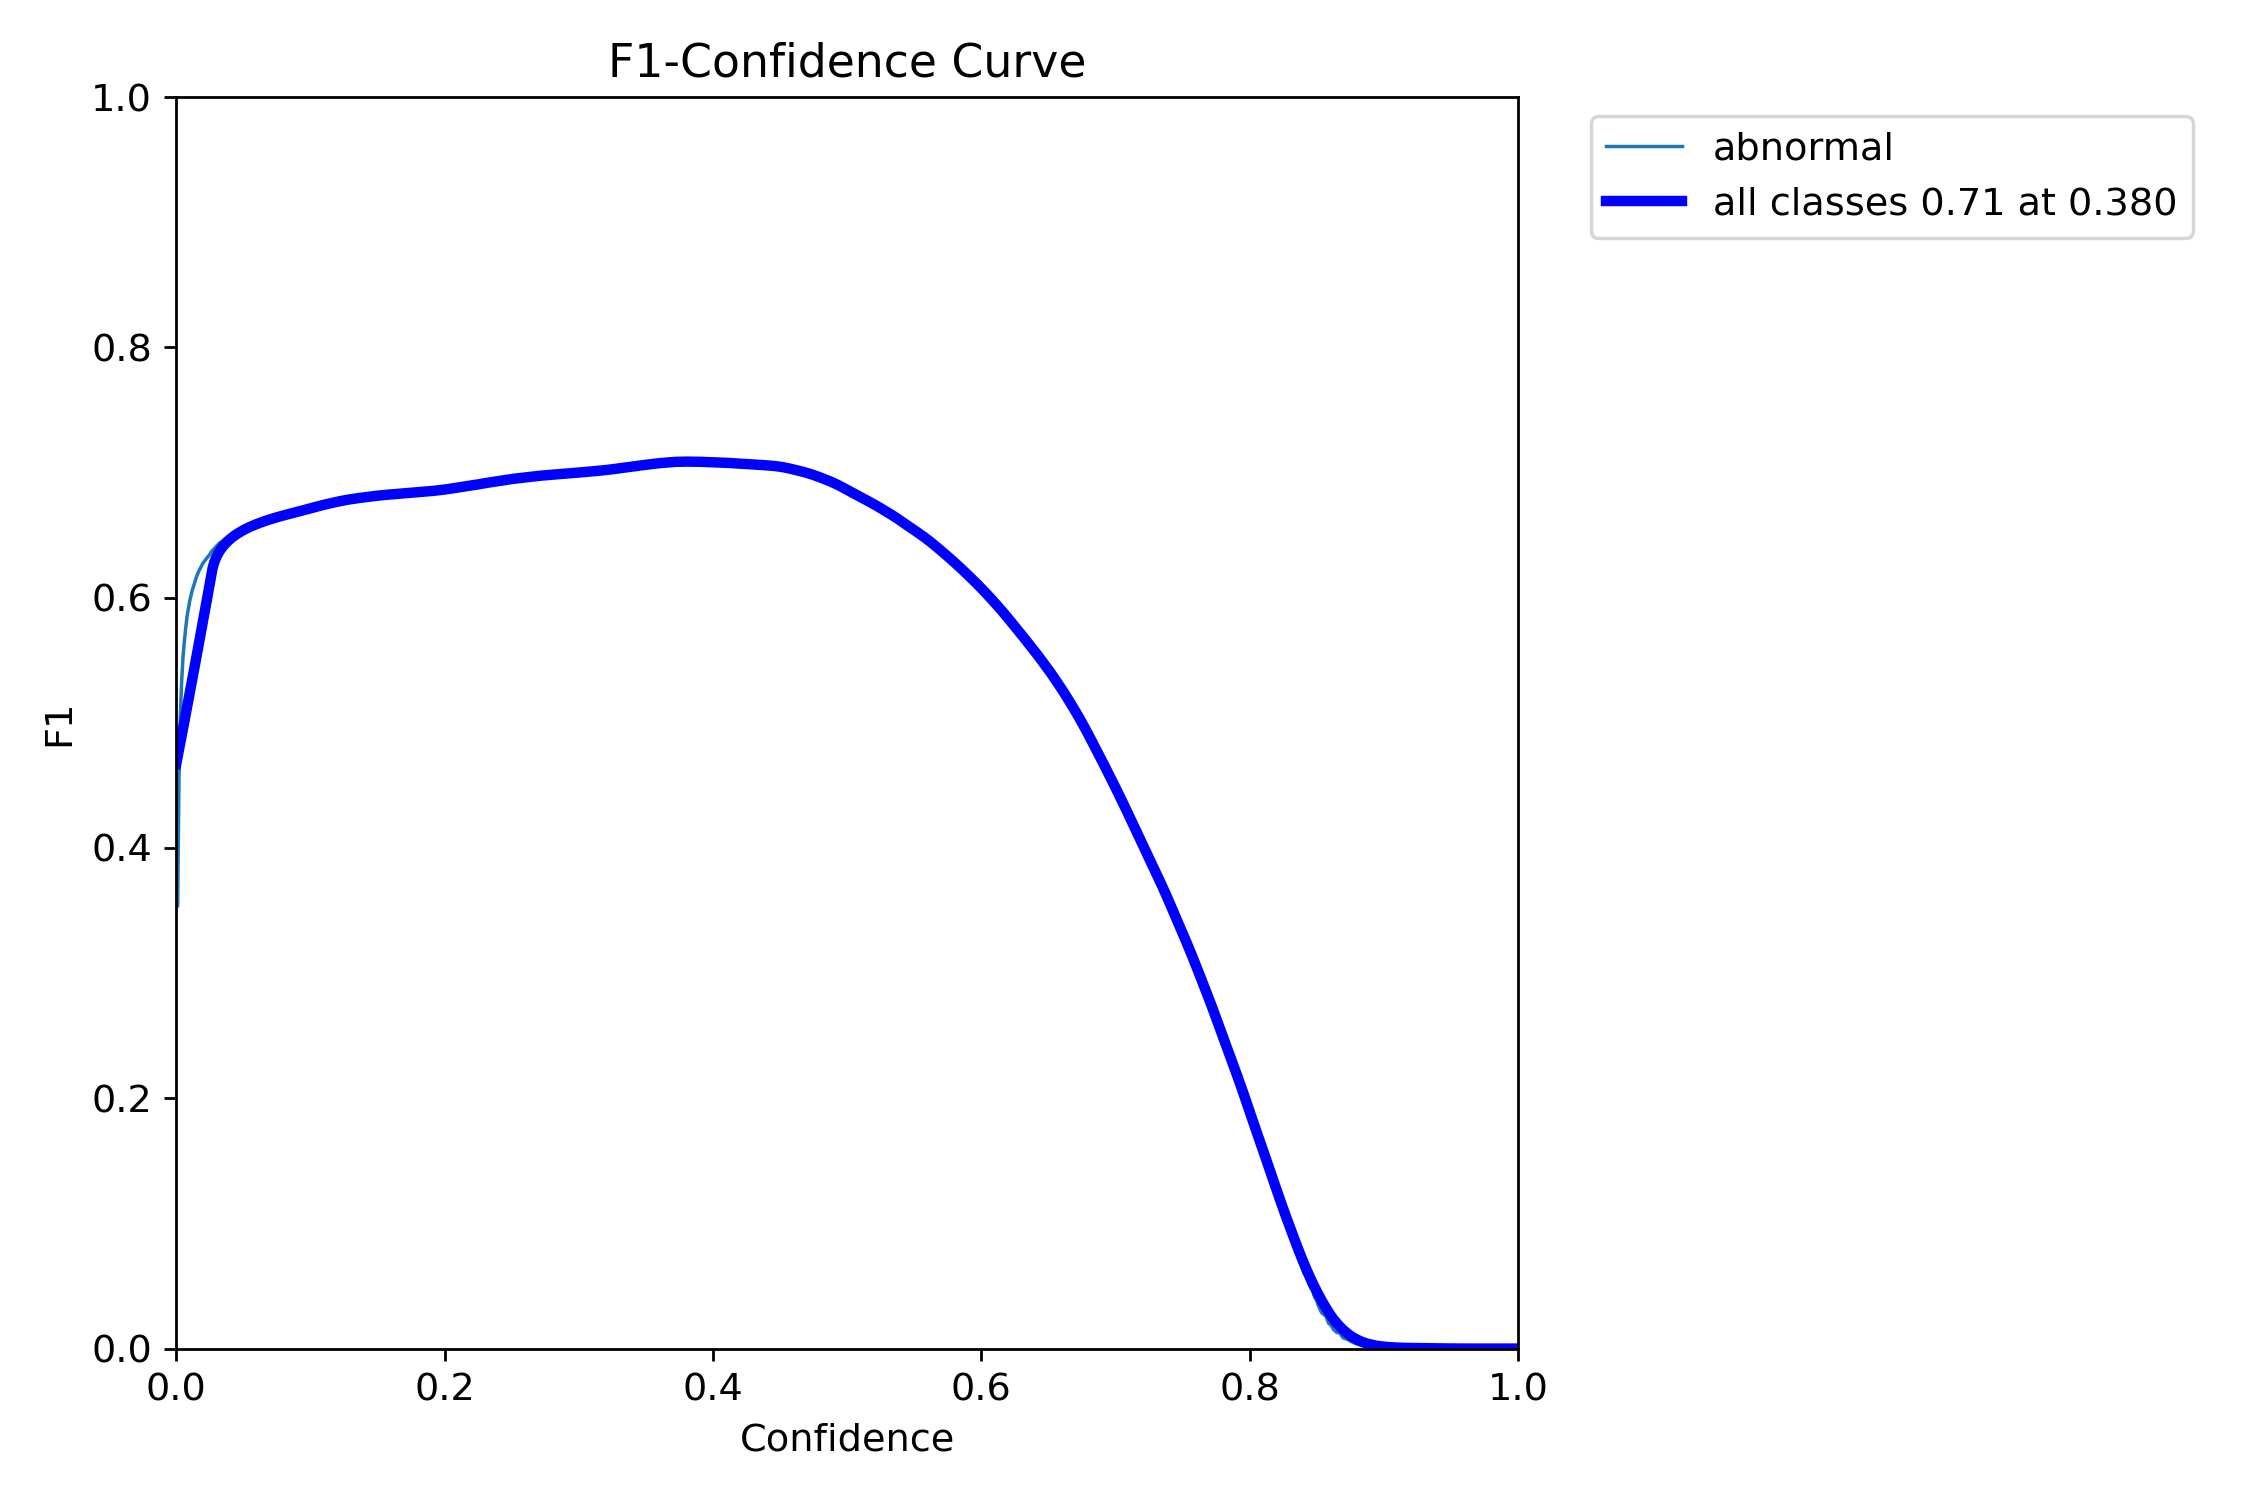

In [28]:
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results/F1_curve.png', width=900)

In [29]:
%cd /kaggle/working/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.5 --source /kaggle/input/valid5/TCGA-BJ-A28V-01Z-00-DX1_24.jpg

/kaggle/working/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/kaggle/input/valid5/TCGA-BJ-A28V-01Z-00-DX1_24.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-313-g712de55a Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /kaggle/input/valid5/TCGA-BJ-A28V-01Z-00-DX1_24.jpg: 640x640 41 abnormals, 27.0ms
Speed: 0.6ms pre-process, 27.0ms inference, 482.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2
